### Imports

In [1]:
%pip install prophet
%pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.8 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 45 kB 2.9 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6641579 sha256=46d700ea5bfabe4d3f946bf294fe11d84854efb37fba84bd74f38c8fe3576954
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
Looking in

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from prophet import Prophet
from lifelines import KaplanMeierFitter

In [ ]:
# Configuration
TRAIN_END = 'd_1913'

DEPTS = ['FOODS_1',
       'FOODS_2', 'FOODS_3']

NUM_ITEMS = 500
THRESH = 7

###1. Data Preprocessing

In [3]:
sales = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/M5/sales_train_evaluation.csv')
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [4]:
sales.dept_id.unique()

array(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1',
       'FOODS_2', 'FOODS_3'], dtype=object)

In [6]:
# Filtering the departments in config
sales = sales[sales.dept_id.isin(DEPTS)]
# sort data
sales = sales.sort_values(by=['item_id', 	'dept_id', 	'cat_id', 	'store_id', 	
                              'state_id'])
# melting sales columns into one column
index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
sales = pd.melt(sales, 
                  id_vars = index_columns, 
                  var_name = 'd', 
                  value_name = 'sales')
# dropping unnecessary columns
sales = sales.drop(['cat_id','state_id','id'], axis=1)
# rolling up store level data on item level
sales = sales.groupby(['dept_id','item_id','d']).agg({'sales':np.sum})\
.reset_index()
# converting column 'd'  to int type for sorting on date
sales['d'] = [val.replace('d_','') for val in sales.d]
sales['d'] = pd.to_numeric(sales.d)
sales = sales.sort_values(by=['dept_id','item_id','d'], ignore_index=True)

### 3. Building Forecast model

In [15]:
sales.head()

,dept_id,item_id,d,sales
0,FOODS_1,FOODS_1_001,d_1,6
1,FOODS_1,FOODS_1_001,d_10,10
2,FOODS_1,FOODS_1_001,d_100,9
3,FOODS_1,FOODS_1_001,d_1000,2
4,FOODS_1,FOODS_1_001,d_1001,12


In [16]:
sales.item_id.unique()

array(['FOODS_1_001', 'FOODS_1_002', 'FOODS_1_003', ..., 'FOODS_3_825',
       'FOODS_3_826', 'FOODS_3_827'], dtype=object)

In [19]:
ITEMS = sales.item_id.unique()[0:NUM_ITEMS]

In [20]:
len(ITEMS)

500

In [26]:
items = sales[sales.item_id.isin(ITEMS)]

#### Prophet model

In [27]:
def build_prophet(df, thresh):

  df['ds'] = pd.date_range(start='2015-01-01', periods=len(df))
  df['y'] = df.sales
  df = df[['ds','y']]

  train = df[:-365]
  train.tail()
  test = df[-365:]
  model = Prophet()
  model.fit(train)
  future = model.make_future_dataframe(365, include_history=False)
  forecast = model.predict(future)
  results = pd.merge(forecast, test, on='ds')
  results = results.set_index('ds').resample('w').sum().reset_index()
  results['ape'] = np.abs((results['yhat'] - results['y'])/results['y'])*100
  
  # expanding MAPE
  results['exp_mape'] = results.ape.expanding(4).mean()
  # print(results[results['exp_mape'] >= thresh].head(1) )
  try:
      thresh_week = results[results['exp_mape'] >= thresh].index[0]+1
  except:
      thresh_week = 52
  return pd.DataFrame({'thresh_week':[thresh_week]})
  


In [28]:
results = items.groupby(['dept_id', 'item_id']).apply(build_prophet,THRESH).reset_index()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
results.head()

thresh_week
dept_id item_id                   
FOODS_1 FOODS_1_001 0            4
        FOODS_1_002 0            4
        FOODS_1_003 0            4
        FOODS_1_004 0            4
        FOODS_1_005 0            4

### Survival and Censors

In [ ]:
results['event'] = 0
results.loc[results.thresh_week < 24,'event'] = 1 

In [ ]:
results

,dept_id,item_id,level_2,thresh_week,event
0,FOODS_1,FOODS_1_001,0,4,1
1,FOODS_1,FOODS_1_002,0,4,1
2,FOODS_1,FOODS_1_003,0,4,1
3,FOODS_1,FOODS_1_004,0,4,1
4,FOODS_1,FOODS_1_005,0,4,1
...,...,...,...,...,...
495,FOODS_2,FOODS_2_281,0,4,1
496,FOODS_2,FOODS_2_282,0,4,1
497,FOODS_2,FOODS_2_283,0,4,1
498,FOODS_2,FOODS_2_284,0,4,1


### KM model

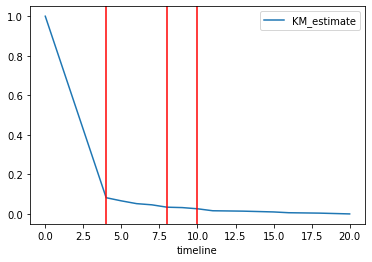

In [ ]:
kmf = KaplanMeierFitter()
kmf.fit(results.thresh_week, results.event)
kmf.survival_function_.plot()
plt.axvline(x=4, color='red')
plt.axvline(x=8, color='red')
plt.axvline(x=10, color='red')

plt.show()